# Monte Carlo Calibration via Deep Learning

## Sample code for calibrating a rough Heston model to SPX options data

This code contains a sample implementation for the *Automatic Monte Carlo Calibration (AMCC)* method introduced in the paper *Monte Carlo Calibration via Deep Learning*.

### Getting started and loading the data

In [1]:
!pip install py_vollib_vectorized
!pip install mpmath
import pandas as pd
import datetime
import numpy as np
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import py_vollib_vectorized
import warnings
import torch
from torch.distributions import Normal
warnings.filterwarnings("ignore")
np.random.seed(1)
from mpmath import hyp2f1

First we need to load the relevant data. In the paper we use Data from OptionMetrics via Wharton Research Data Services (WRDS).

The data file needs to contain a list of contracts with the following attributes:

- **date**  (e.g. '2013-08-17')
- **exdate** (maturity of the contract in the same format)
- **cp_flag** ('p' for put, 'c' for call)
- **strike**
- **best_bid** (best bid price)
- **best_offer** (best ask price)
- **volume**
- **forward_price** (SPX forward)
- **midP** (mid price of contract)
- **maturity** (time-to-maturity as float)
- **Spot** 	(SPX spot)
- **bid_vols** (implied volatility for best bid price)
- **offer_vols** (implied volatility for best ask price)
- **mid_vols** (implied volatility for mid price)

In [2]:
## When running on colab, upload of data works best by activating this celL:
if False:
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))

In [3]:
## Once uploaded, we load the data into a pandas dataframe.

data_full = pd.read_csv('IV_data2017.csv')
data_full = data_full.dropna()

In [4]:
dates = data_full.drop_duplicates('date')['date'].tolist()
print(dates)
## Select the relevant dates here
dates = dates[0:25]
data_full.allDates = dates
data_full.count()[0]

['2017-05-19', '2017-05-22', '2017-05-23', '2017-05-24', '2017-05-25', '2017-05-26', '2017-05-30', '2017-05-31', '2017-06-01', '2017-06-02', '2017-06-05', '2017-06-06', '2017-06-07', '2017-06-08', '2017-06-09', '2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15', '2017-06-16', '2017-06-19', '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29', '2017-06-30']


59789

In [5]:
## Only use part of the data for training: specify volume threshold here.
threshold =  1000
data = data_full[data_full['volume']>threshold]
data=data.dropna()
data.allDates = dates

In [6]:
data.count()[0]/data_full.count()[0]

0.09018381307598387

In [7]:
data

,date,exdate,last_date,cp_flag,strike,best_bid,best_offer,volume,impl_volatility,contract_size,forward_price,midP,maturity,Spot,Fwd,discountFactor,bid_vols,offer_vols,mid_vols
0,2017-05-19,2017-06-16,20170519.0,c,2385.0,20.6,21.90,12829,0.091010,100,2380.328343,21.250,0.076661,2381.729980,0.0,0.0,0.086832,0.091786,0.089309
1,2017-05-19,2017-06-16,20170519.0,c,2390.0,17.7,18.80,1102,0.087999,100,2380.328343,18.250,0.076661,2381.729980,0.0,0.0,0.084242,0.088477,0.086360
3,2017-05-19,2017-06-16,20170519.0,c,2400.0,12.8,13.70,17454,0.083643,100,2380.328343,13.250,0.076661,2381.729980,0.0,0.0,0.080273,0.083912,0.082095
5,2017-05-19,2017-06-16,20170519.0,c,2410.0,8.6,9.40,1201,0.078961,100,2380.328343,9.000,0.076661,2381.729980,0.0,0.0,0.075715,0.079286,0.077507
7,2017-05-19,2017-06-16,20170519.0,c,2420.0,5.4,6.10,7523,0.074870,100,2380.328343,5.750,0.076661,2381.729980,0.0,0.0,0.071647,0.075319,0.073498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59698,2017-06-30,2017-09-29,20170630.0,p,1450.0,0.3,0.45,5305,0.380121,100,2420.347622,0.375,0.249150,2423.409912,0.0,0.0,0.371606,0.387216,0.379994
59704,2017-06-30,2017-09-29,20170630.0,p,1950.0,3.2,3.50,3204,0.236121,100,2420.347622,3.350,0.249150,2423.409912,0.0,0.0,0.234093,0.237826,0.235985
59724,2017-06-30,2017-09-29,20170630.0,p,2300.0,22.0,22.40,3949,0.139650,100,2420.347622,22.200,0.249150,2423.409912,0.0,0.0,0.138890,0.140004,0.139447
59810,2017-06-30,2017-12-29,20170630.0,p,2000.0,13.3,13.70,3000,0.202911,100,2417.934098,13.500,0.498299,2423.409912,0.0,0.0,0.201768,0.203329,0.202551


### Defining auxiliary functions

In [13]:
from scipy.special import gamma
def kernel(time_points,hurst_exp):

    kernels = time_points**(hurst_exp-0.5)/gamma(hurst_exp+0.5)

    return kernels

Next we build two dictionaries that will be useful when accessing the data.

In [14]:
df = data_full[data_full['date']==dates[0]]
exdates = df.drop_duplicates('exdate')['exdate'].tolist()
print(exdates)

dfDict = {}
for t in data_full.allDates:
    dfT = data_full.loc[data_full['date'] == t]
    allMats = dfT.drop_duplicates('exdate')['exdate'].tolist()
    dfDict[t] = []
    for tau in allMats:
        dfTtau = dfT[dfT["exdate"] == tau]
        dfDict[t].append((dfTtau, tau))
data_full.dfDict=dfDict

['2017-06-16', '2017-07-21', '2017-08-18', '2017-09-15', '2017-12-15', '2018-01-19', '2018-03-16', '2018-06-15', '2018-12-21', '2019-12-20', '2017-05-22', '2017-05-24', '2017-05-26', '2017-05-30', '2017-05-31', '2017-06-02', '2017-06-05', '2017-06-07', '2017-06-09', '2017-06-12', '2017-06-14', '2017-06-19', '2017-06-21', '2017-06-23', '2017-06-26', '2017-06-28', '2017-06-30', '2017-07-07', '2017-07-14', '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31', '2017-12-29', '2018-03-29']


In [15]:
df = data[data['date']==dates[0]]
exdates = df.drop_duplicates('exdate')['exdate'].tolist()
print(exdates)

for exdate in exdates:
    df_tau = df[df['exdate']==exdate]

dfDict = {}
for t in data.allDates:
    dfT = data.loc[data['date'] == t]
    allMats = dfT.drop_duplicates('exdate')['exdate'].tolist()
    dfDict[t] = []
    for tau in allMats:
        dfTtau = dfT[dfT["exdate"] == tau]
        dfDict[t].append((dfTtau, tau))
data.dfDict=dfDict

['2017-06-16', '2017-07-21', '2017-08-18', '2017-09-15', '2017-12-15', '2018-01-19', '2018-06-15', '2018-12-21', '2017-05-22', '2017-05-24', '2017-05-26', '2017-05-30', '2017-05-31', '2017-06-02', '2017-06-07', '2017-06-09', '2017-06-19', '2017-06-23', '2017-06-26', '2017-06-30', '2017-07-14', '2017-07-31', '2017-08-31']


Check how many datapoints you are using approximately per day.

In [16]:
counter = 0.
for i in range(len(dates)):
    counter = counter + data[data['date'] == dates[i]].count()[0]
print(counter / len(dates))

179.48


In [40]:
hidden_size=10
class FNN_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1),
            torch.nn.Softplus()
        )
    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out
FNN = FNN_model()

### Calibration

Here we define the object used for calibration.

In [48]:
class Rough_Heston_calibration():

    def __init__(self,select_date_ind=0):
        self.v0 =  torch.tensor(0.02)
        self.sigma =  torch.tensor(0.4061)
        self.kappa = torch.tensor(0.2)
        self.theta = torch.tensor(0.)
        self.iter_numb = 1
        self.learning_rate = 0.01
        self.errorMessage = False
        self.batch_size = torch.tensor(25000)
        self.time_steps = 50
        self.xi=torch.ones(30)
        self.time_steps_t = torch.tensor(self.time_steps)
        self.r0=torch.tensor(0.0)
        self.hurst = torch.tensor(0.0474) #torch.tensor(0.05)
        self.rho = torch.tensor(-0.6710)
        self.sqrt_rho = torch.sqrt(1-self.rho**2)
        self.select_date_ind = select_date_ind
        self.use_NN_fwc = True


    def select_data(self, data, select_date_ind, select_mat_ind):
        '''
        Load data for date specified by index and maturity specified by index and set
        object parameters (time-grid, maturity,...) accordingly.
        '''
        if (select_date_ind >= 0) & (select_date_ind < len(data.allDates)):

            self.o = data.allDates[select_date_ind] ## Select one particular day

            if (select_mat_ind >= 0) & (select_mat_ind < len(data.dfDict[self.o])):

                df_extract = data.dfDict[self.o][select_mat_ind]
            else:
                self.errorMessage = True
        else:
            self.errorMessage = True

        if self.errorMessage:
            print("No data available. Please choose other")

        else:
            self.Tau = df_extract[1]
            df = df_extract[0]

            self.data = df
            self.forward = torch.tensor(np.array(self.data["forward_price"])[0])
            self.strikes = torch.tensor(np.array(self.data["strike"]))
            self.ivs_market = torch.tensor(np.array(self.data["mid_vols"]))
            self.ivs_bid = torch.tensor(np.array(self.data["bid_vols"]))
            self.ivs_offer = torch.tensor(np.array(self.data["offer_vols"]))
            self.mids = self.data["midP"]
            self.bids = self.data['best_bid']
            self.offers = self.data['best_offer']
            self.spot = torch.tensor(np.array(self.data['Spot'])[0])
            self.maturity = torch.tensor(np.array(self.data["maturity"].iloc[0]))
            self.h = torch.tensor(self.maturity/self.time_steps).float()
            self.pc_factor = torch.tensor(np.array(2.*(df_extract[0]["cp_flag"] == "c")-1.))
            self.logStrikes = -np.log(df["forward_price"] / df["strike"])
            self.cp_flag = df_extract[0]["cp_flag"]
            #self.theta_curve = self.market_curve()
            if self.use_NN_fwc:
                self.variance_curve = self.forward_variance_curve_nn()
            else:
                self.variance_curve = self.forward_variance_curve()

    def forward_variance_curve(self):
        '''
        Evaluate piecewise linear forward variance curve at time points defined by current grid.
        '''
        variance_curve = torch.ones(self.time_steps)
        time_grid = self.h*torch.arange(1,self.time_steps+1)
        for k in range(10):
            indices = time_grid>k*0.0025
            indices[time_grid<=(k-1)*0.0025]=False
            variance_curve[indices] = torch.abs(self.xi[k])
        for k in range(1,10):
            indices = time_grid>k*0.025
            indices[time_grid<=(k-1)*0.025]=False
            variance_curve[indices] = torch.abs(self.xi[k+9])
        for k in range(1,10):
            indices = time_grid>k*0.25
            indices[time_grid<=(k-1)*0.25]=False
            variance_curve[indices] = torch.abs(self.xi[k+18])
        return variance_curve

    def forward_variance_curve_nn(self):
        '''
        Evaluate neural network forward variance curve at time points defined by current grid.
        '''

        variance_curve = torch.ones(self.time_steps)
        time_grid = (self.h*torch.arange(1,self.time_steps+1)).reshape(self.time_steps,1)
        variance_curve = FNN(time_grid)
        return variance_curve


    #def market_curve(self):
    #    '''
    #    Evaluate neural network market price of risk curve at time points defined by current grid.
    #    '''
#
#        curve = torch.ones(self.time_steps)
#        time_grid = (self.h*torch.arange(1,self.time_steps+1)).reshape(self.time_steps,1)
#        curve = FNN(time_grid)
#        return curve

    
    def payoff(self,samples):
        '''
        Evaluate put / call payoffs
        '''

        diff_tmp = samples.reshape(-1,1)-self.strikes
        diff_tmp = diff_tmp * self.pc_factor
        diff_tmp [diff_tmp  < 0] = 0

        return diff_tmp

    def simulated_paths_rough_heston(self,states_in,path_bm,path_bm_2):
        '''
        Generate sample paths of the rough Heston model using an approximate sampling scheme
        '''

        vec_dim = path_bm_2.shape
        time_steps = vec_dim[1]

        log_states = torch.log(states_in)
        vol_states = torch.ones(vec_dim[0])*self.v0
        v_plus = torch.max(vol_states,torch.tensor([0.00001]))

        hist_alt = torch.zeros(vec_dim[0],time_steps+1)

        for i in range(time_steps):
            hist_alt[:,i] = self.kappa*(self.theta-v_plus)*self.h+torch.mul(self.sigma*torch.sqrt(v_plus),path_bm[:,i])
            vec_tmp = self.h*(i + 1 - torch.arange(0, i+1))
            kernels = kernel(vec_tmp,self.hurst)

            brownian_incr_v = path_bm[:,i]
            brownian_incr_s = self.rho*brownian_incr_v + self.sqrt_rho*path_bm_2[:,i]

            vol_states =  vol_states + torch.matmul(hist_alt[:,0:(i+1)],kernels)
            log_states = log_states + (self.r0-0.5*v_plus)*self.h+torch.sqrt(v_plus)*brownian_incr_s
            
            vol_states = self.variance_curve[i]*vol_states
            
            v_plus = torch.max(vol_states,torch.tensor([0.00001]))

        return torch.exp(log_states)






    def call_rough_heston_anti(self,num_samples):
        '''
        Compute option prices in the rough Heston model using the approximate sampling scheme
        '''

        init_states  = torch.ones(num_samples)*self.spot
        paths_bm_test = torch.normal(0, 1, (num_samples,self.time_steps_t))*torch.sqrt(self.h)
        paths_bm_test_2 = torch.normal(0, 1, (num_samples,self.time_steps_t))*torch.sqrt(self.h)

        samples_test= self.simulated_paths_rough_heston(init_states,paths_bm_test,paths_bm_test_2)
        samples_test_anti= self.simulated_paths_rough_heston(init_states,-paths_bm_test,-paths_bm_test_2)



        return (torch.mean(torch.transpose(self.payoff(samples_test),0,1),dim=1) + torch.mean(torch.transpose(self.payoff(samples_test_anti),0,1),dim=1))/2



    def AMCC_optim(self,iter_numb,select_date_ind=0):
        '''
        Perform Monte Carlo Calibration using AMCC
        '''

        self.v0.requires_grad = True
        self.kappa.requires_grad = True
        self.rho.requires_grad= True
        self.sigma.requires_grad = True
        self.theta.requires_grad = True
        #self.hurst.requires_grad = True
        param_list = [self.v0,self.kappa,self.theta,self.sigma,self.rho]#self.hurst]
        if self.use_NN_fwc:
            param_list = list(FNN.parameters())+param_list
        else:
            self.xi.requires_grad = True
            param_list = param_list + [self.xi]
        optimizer = torch.optim.Adam(param_list, lr=self.learning_rate)
        FNN.train()
        for itr in range(iter_numb):
            loss = torch.tensor(0.)
            for i in range(len(dfDict[data.allDates[select_date_ind]])):
                self.select_data(data,select_date_ind,i)
                prices = self.call_rough_heston_anti(self.batch_size)
                market_data = torch.tensor(np.array(self.mids))
                difference = (torch.exp(-self.r0*self.maturity)*prices - market_data)
                loss =loss + torch.sum((difference)**2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if itr%3==0:
                print("Epoch number: {} and the loss : {}".format(itr,loss.item()))




    def AMCC_calibrate(self, plot_maturities = [0,1],print_options = [True, True]):
        '''
        Carry out AMCC and print results
        '''

        self.AMCC_optim(self.iter_numb,self.select_date_ind)
        if print_options[0]:
            print("Optimal parameters: ")
            print("v_0 = ", self.v0.detach().numpy().item(0))
            print("\theta = ", self.theta.detach().numpy().item(0))
            print("\kappa = ", self.kappa.detach().numpy().item(0))
            print("\sigma = ", self.sigma.detach().numpy().item(0))
            print("\rho = ", self.rho.detach().numpy().item(0))
            print("H = ", self.hurst.detach().numpy().item(0))
        if print_options[1]:
            for maturities_ind in plot_maturities:
                date = dates[self.select_date_ind]
                self.select_data(data,self.select_date_ind,maturities_ind)
                market_data = torch.tensor(np.array(self.ivs_market))
                model_prices = self.evaluate(300000)

                iv_RB = py_vollib_vectorized.implied_volatility.vectorized_implied_volatility(model_prices.detach().numpy(),np.array(self.spot),np.array(self.strikes),np.array(self.maturity),np.array(self.r0),self.cp_flag)
                plt.figure(figsize=(6, 3))
                plt.plot(self.logStrikes, self.ivs_market, 'bo', fillstyle='none',label='Market')
                plt.plot(self.logStrikes, iv_RB, 'g+',label='RH')
                plottitle = "Date: " + str(date)
                plottitle+= " || maturity: " + str(self.Tau)
                plt.title(plottitle)
                plt.legend()
                plt.show()
                plt.figure(figsize=(6, 3))
                plt.plot(self.logStrikes, self.mids, 'bo', fillstyle='none',label='Market')
                plt.plot(self.logStrikes, model_prices.detach().numpy(), 'g+',label='RB')
                plottitle = "Date: " + str(date)
                plottitle+= " || maturity: " + str(self.Tau)
                plt.title(plottitle)
                plt.legend()
                plt.show()
                print(np.mean(np.array(iv_RB)-np.array(self.ivs_market))**2)

    def evaluate(self,test_num_samples,select_date_ind=0):
        FNN.eval()
        with torch.no_grad():
                model_prices = torch.exp(-self.r0*self.maturity)*self.call_rough_heston_anti(test_num_samples)
        return model_prices










def evaluate_RMSE(data,model,show_plots=False):
    '''
       Evaluate model fit to data.
    '''
    select_date_ind = model.select_date_ind
    with torch.no_grad():
        loss = 0.
        count = 0.
        date = data.allDates[select_date_ind]
        hits_count = 0.
        mape = 0.
        delta_s = 0.
        price_metric = 0.
        for i in range(len(dfDict[date])):
            model.select_data(data,select_date_ind,i)
            model_prices = (model.evaluate(100000)).detach().numpy()
            implied_vols = py_vollib_vectorized.implied_volatility.vectorized_implied_volatility(model_prices,np.array(model.forward),np.array(model.strikes),np.array(model.maturity),np.array(model.r0),model.cp_flag)
            market_data = np.array(model.ivs_market)
            market_prices = np.array(model.mids)
            loss =loss + np.sum((np.array(implied_vols) - market_data)**2)#,dim=1)
            mape = mape + np.sum(np.abs((np.array(implied_vols) - market_data))/(market_data))#,dim=1)
            count = count + market_data.shape[0]
            if show_plots:
                plt.figure(figsize=(6, 3))
                plt.plot(model.logStrikes, market_data, 'bo', fillstyle='none',label='Mid')
                plt.plot(model.logStrikes, np.array(model.ivs_bid), 'rx', fillstyle='none',label='Bid')
                plt.plot(model.logStrikes, np.array(model.ivs_offer), 'mx', fillstyle='none',label='Ask')
                plt.plot(model.logStrikes, implied_vols, 'g+',label='Rough Heston')
                plottitle = "Date: " + str(date)
                plottitle+= " || maturity: " + str(model.Tau)
                plt.title(plottitle)
                plt.legend()
                plt.xlabel('Log-moneyness')
                plt.ylabel('Implied Volatility')
                nameFile = "RoughHeston_" +str(date)+ "_" + str(model.Tau)+".png" #str(pd.to_datetime(model.Tau)-pd.to_datetime(dates[0])) + ".png"
                plt.savefig(nameFile,bbox_inches='tight')
                plt.show()
            hits = (np.array(model.ivs_bid)<np.array(implied_vols).T)*(np.array(model.ivs_offer)>np.array(implied_vols).T)
            print(np.sum(hits)/implied_vols.shape[0])
            hits_count = hits_count + np.sum(hits)
            price_metric = price_metric + np.sum(((model_prices-market_prices)/np.array(model.spot))<(1./100.))
            spread = np.array(model.offers)-np.array(model.bids)
            delta_s = delta_s + np.sum(2*np.abs(model_prices-np.array(model.mids))/spread)
            #print(np.sum(hits))
    print('Loss:',np.sqrt(loss/count)) ## Mean-squared implied volatility error
    print('MAPE:',mape/count) ## Mean absolute percentage error
    print('Hits:', hits_count/count) ## Hits
    print('Delta_spread:',delta_s/count) ## Error relative to spread
    print('Market metric:',price_metric/count)
    return((np.sqrt(loss/count))), hits_count/count,  delta_s/count


In [49]:
## Initiate calibration
RH = Rough_Heston_calibration()
RH.use_NN_fwc = False
RH.iter_numb = 500
RH.learning_rate = 0.01

In [50]:
## Carry out calibration with fixed Hurst parameter
maturities_list = list(range(len(dfDict[data.allDates[0]])))
RH.AMCC_calibrate(print_options = [True, True], plot_maturities=maturities_list)

Epoch number: 0 and the loss : 19875.636957798888
Epoch number: 3 and the loss : 10810.560590971038
Epoch number: 6 and the loss : 16301.169938098672
Epoch number: 9 and the loss : 19676.788050461157


KeyboardInterrupt: 

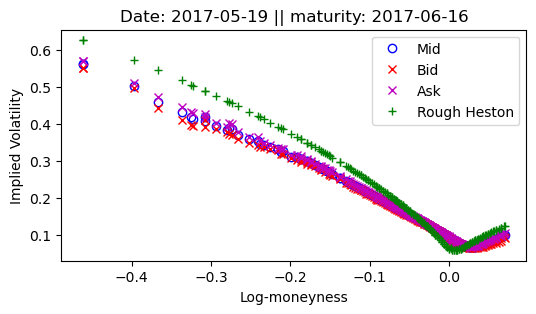

0.02512562814070352


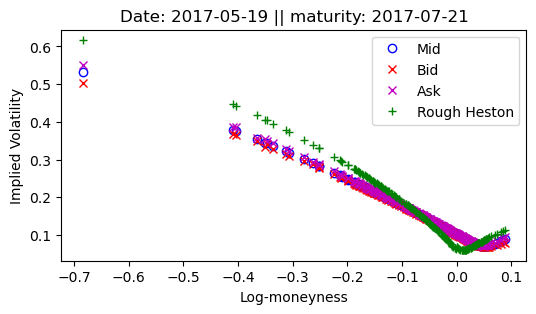

0.031746031746031744


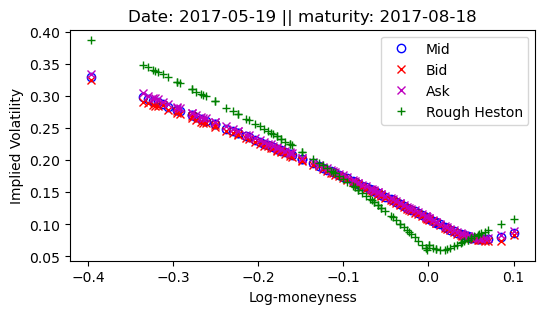

0.04672897196261682


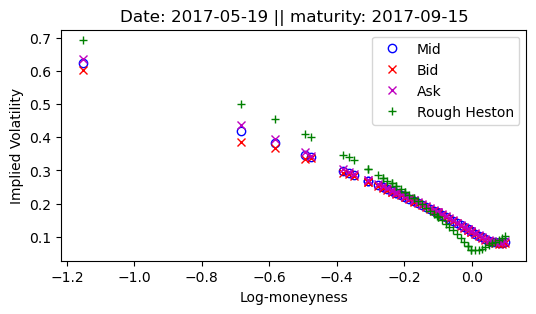

0.018867924528301886


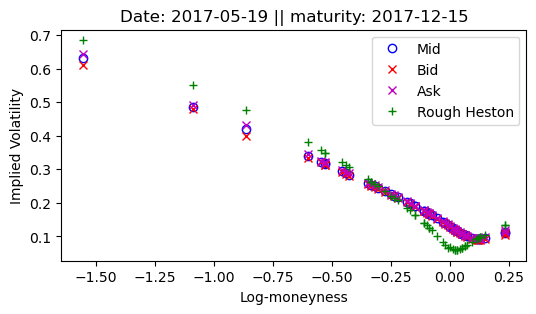

0.037037037037037035


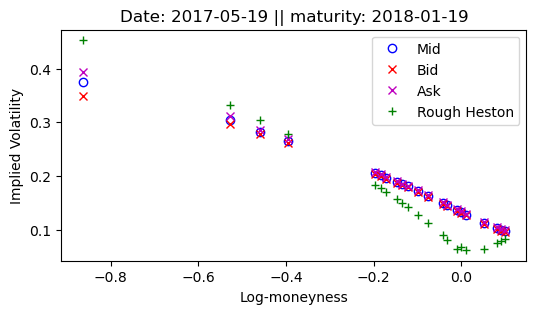

0.0


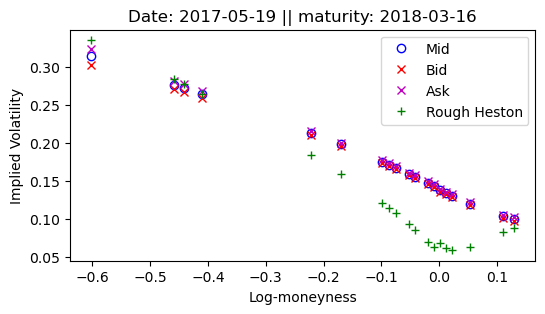

0.10526315789473684


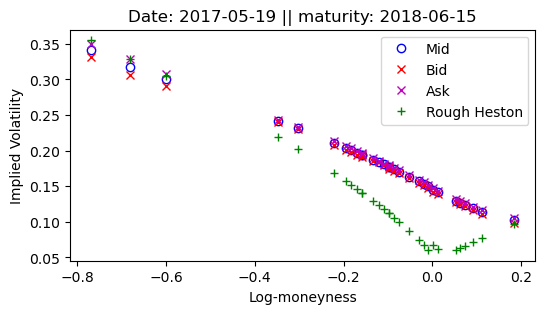

0.03333333333333333


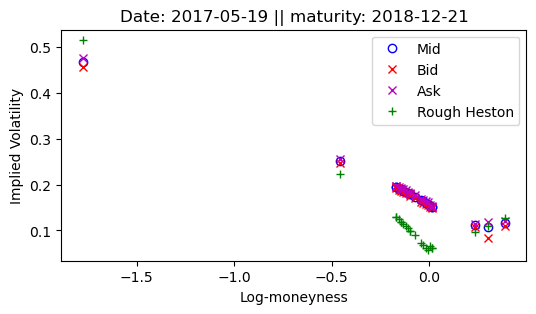

0.043478260869565216


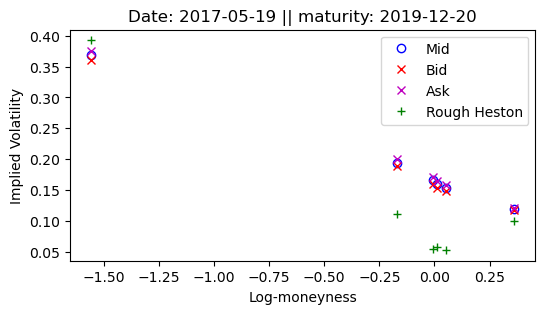

0.0


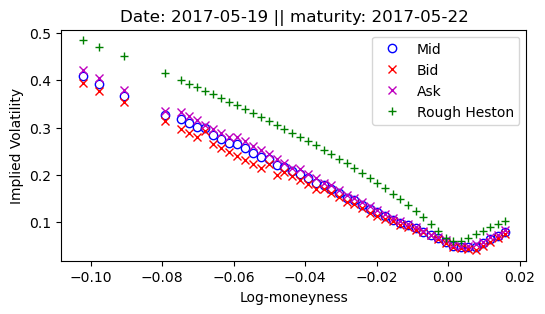

0.0


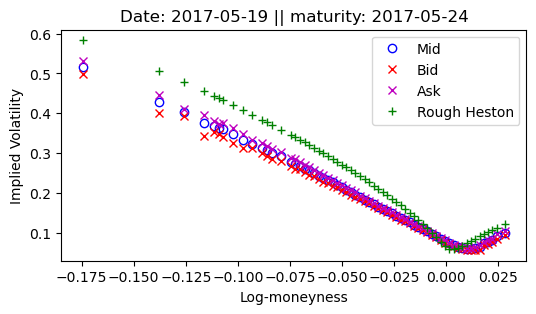

0.016129032258064516


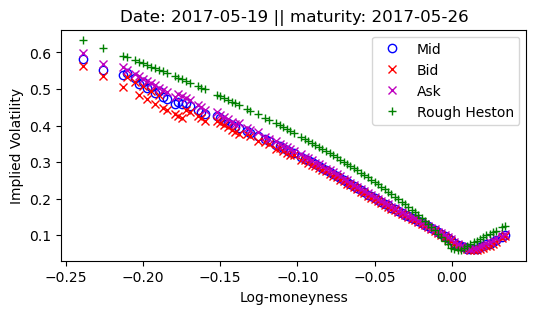

0.02


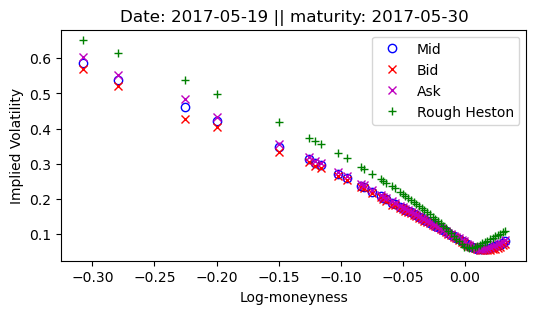

0.01694915254237288


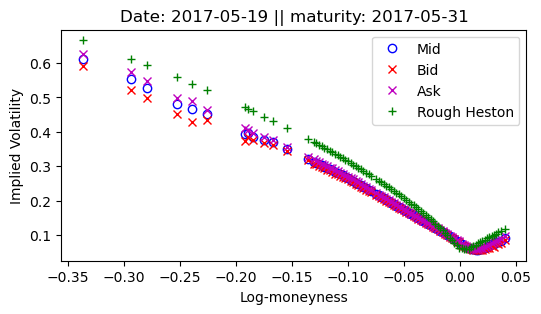

0.011111111111111112


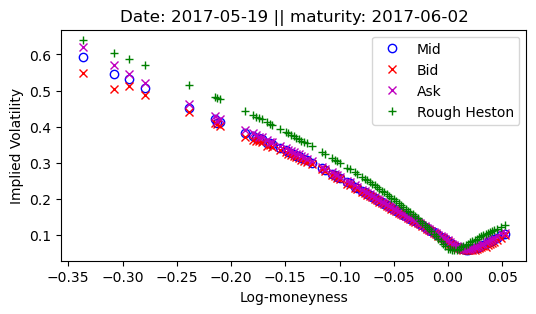

0.0


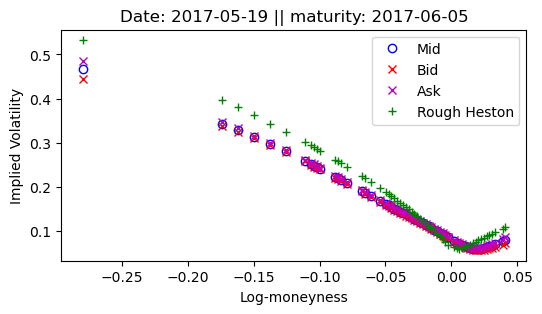

0.03333333333333333


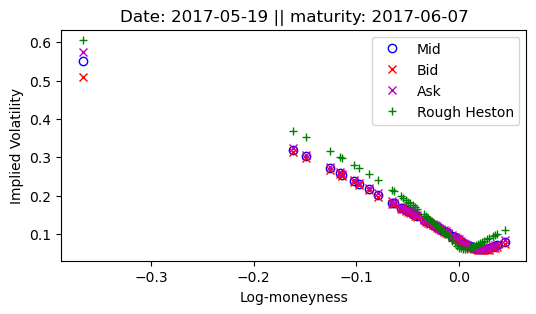

0.05555555555555555


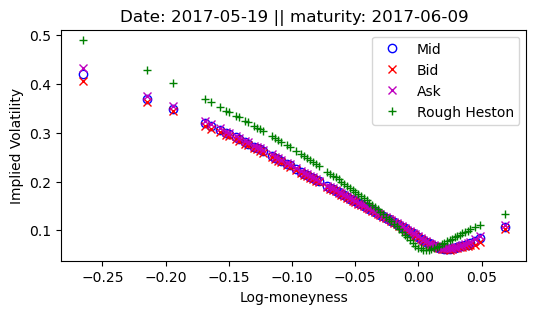

0.022988505747126436


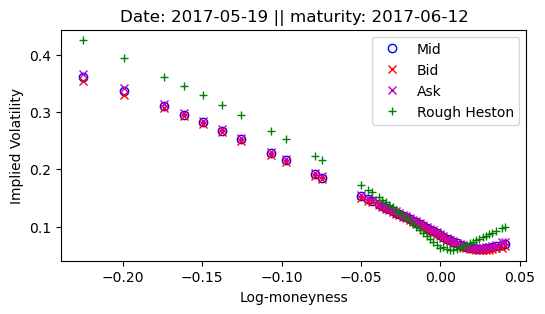

0.038461538461538464


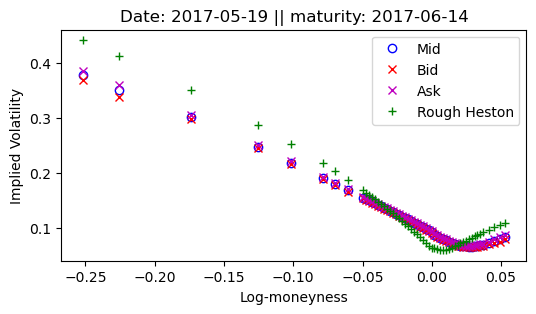

0.05555555555555555


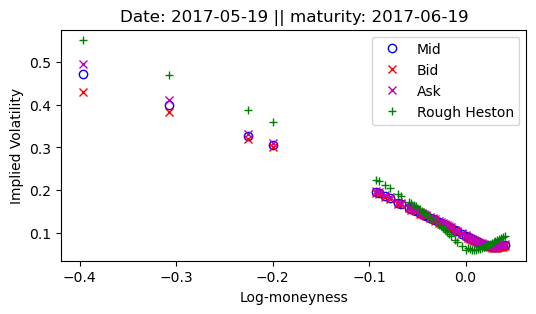

0.057692307692307696


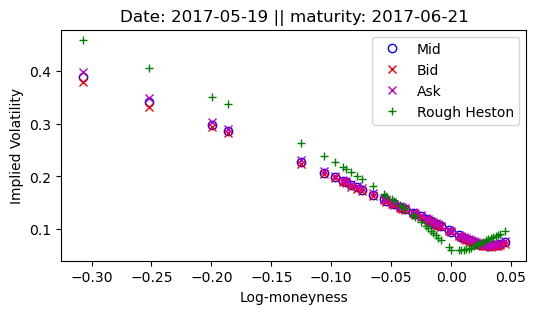

0.058823529411764705
Loss: 1.5957573478019373
MAPE: 86.91351640536637
Hits: 0.029355456285896617
Delta_spread: 14.346175645123084
Market metric: 1.0


In [51]:



loss,hits, delta = evaluate_RMSE(data_full,RH,show_plots=True)

In [35]:
### Set to true to evaluate using the initial parameters. 
if False:  
    RH.sigma =  torch.tensor(0.4061)
     
    RH.rho = torch.tensor(-0.6710)
    RH.sqrt_rho = torch.sqrt(1-RH.rho**2)
    
    
    ## Evaluate performance on original parameters. 

    loss,hits,delta = evaluate_RMSE(data_full,RH,show_plots=False)
        
   


0.20588235294117646
0.010752688172043012
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Loss: 0.6861323561391212
MAPE: 25.54972344582624
Hits: 0.018561484918793503
Delta_spread: 8.113393757503488
Market metric: 0.9582366589327146


In [ ]:
### Calibrate also for subsequent dates, using the previous parameters as starting point.

loss_list = [loss]
hits_list = [hits]
delta_list = [delta]
for i in range(1,len(dates)):
    RH.select_date_ind = i
    maturities_list = list(range(len(dfDict[data.allDates[i]])))
    RH.AMCC_calibrate(print_options = [True, False], plot_maturities=maturities_list)
    loss,hits,delta = evaluate_RMSE(data_full,RH,show_plots=False)
    loss_list.append(loss)
    hits_list.append(hits)
    delta_list.append(delta)
print(loss_list)
print(hits_list)
print(delta_list)

In [ ]:
### Print and plot the MSE
plt.figure()
plt.plot(dates,loss_list,'gx')
tickslist=[dates[i] for i in range(0,len(dates),3)]
tickslist.append(dates[-1])
plt.xticks(tickslist)
plt.ylabel('Mean-squared error')
plt.savefig('MSE')
plt.show()